In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.impute import SimpleImputer
# Basic packages
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, gc
from scipy import stats; from scipy.stats import zscore, norm, randint
import matplotlib.style as style; style.use('fivethirtyeight')

# Display settings
pd.options.display.max_rows = 400
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format

random_state = 42
np.random.seed(random_state)

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

data = pd.read_csv('../input/malnutrition-across-the-globe/malnutrition-estimates.csv')
data_by_country = pd.read_csv('../input/malnutrition-across-the-globe/country-wise-average.csv')
data.drop(['Unnamed: 0','ISO code','Survey Year','Source','Report Author','Notes','Short Source'], axis=1, inplace=True)

def income_map(val):
    mapper = {0:'Low Income', 1:'Lower Middle Income', 2:'Upper Middle Income',3:'High Income'}
    return mapper[val]
def lldc_map(val):
    mapper = {0:'Others', 2:'SIDS', 1:'LLDC'}
    return mapper[val]

data['Income Classification'] = data['Income Classification'].apply(income_map)
data['LLDC or SID2'] = data['LLDC or SID2'].apply(lldc_map)

In [3]:
#from IPython.display import Image
#Image("../input/nifty50/Capture.PNG")
#source: https://www.slideshare.net/souravgoswami11/epidemiology-of-childhood-malnutrition-in-india-and-strategies-of-control

Malnutrition is a condition that results from eating a diet in which one or more nutrients are either not enough or are too much such that the diet causes health problems. It may involve calories, protein, carbohydrates, fat, vitamins or minerals. Not enough nutrients is called undernutrition or undernourishment while too much is called overnutrition. 

People also often get infections and are frequently cold. The symptoms of micronutrient deficiencies depend on the micronutrient that is lacking. [Source](https://en.wikipedia.org/wiki/Malnutrition).

# Import Data and Overview

In [4]:
data.head()

,Country,Year,Income Classification,LDC,LIFD,LLDC or SID2,Survey Sample (N),Severe Wasting,Wasting,Overweight,Stunting,Underweight,U5 Population ('000s)
0,AFGHANISTAN,1997,Low Income,1.00,1.00,LLDC,"4,846",nan,18.20,6.50,53.20,44.90,3838.88
1,AFGHANISTAN,2004,Low Income,1.00,1.00,LLDC,946,3.50,8.60,4.60,59.30,32.90,4789.35
2,AFGHANISTAN,2013,Low Income,1.00,1.00,LLDC,"44,26,469",4.00,9.50,5.30,40.40,24.60,5444.57
3,AFGHANISTAN,2018,Low Income,1.00,1.00,LLDC,NaN,1.60,5.10,4.10,38.20,19.10,5601.44
4,ALBANIA,1997,Upper Middle Income,0.00,0.00,Others,"7,642",nan,8.10,9.50,20.40,7.10,309.23


In [5]:
data.columns

Index(['Country', 'Year', 'Income Classification', 'LDC', 'LIFD',
       'LLDC or SID2', 'Survey Sample (N)', 'Severe Wasting', 'Wasting',
       'Overweight', 'Stunting', 'Underweight', 'U5 Population ('000s)'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                924 non-null    object 
 1   Year                   924 non-null    int64  
 2   Income Classification  924 non-null    object 
 3   LDC                    924 non-null    float64
 4   LIFD                   924 non-null    float64
 5   LLDC or SID2           924 non-null    object 
 6   Survey Sample (N)      861 non-null    object 
 7   Severe Wasting         696 non-null    float64
 8   Wasting                877 non-null    float64
 9   Overweight             788 non-null    float64
 10  Stunting               887 non-null    float64
 11  Underweight            902 non-null    float64
 12  U5 Population ('000s)  924 non-null    float64
dtypes: float64(8), int64(1), object(4)
memory usage: 94.0+ KB


In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,924.00,2003.73,8.79,1983.00,1996.00,2004.50,2011.00,2019.00
LDC,924.00,0.35,0.48,0.00,0.00,0.00,1.00,1.00
LIFD,924.00,0.42,0.49,0.00,0.00,0.00,1.00,1.00
Severe Wasting,696.00,2.19,1.91,0.00,0.80,1.60,2.90,12.90
Wasting,877.00,6.96,5.04,0.00,2.90,5.90,9.70,25.30
Overweight,788.00,6.43,4.64,0.00,2.90,5.50,8.70,30.10
Stunting,887.00,29.06,15.83,0.00,16.65,29.20,40.20,73.60
Underweight,902.00,15.84,12.51,0.00,4.93,13.40,23.10,66.80
U5 Population ('000s),924.00,6182.70,16795.94,1.00,559.67,1795.52,4194.21,132966.78


# Handling Missing values

In [8]:
# Check missing values in the dataframe
data.isnull().sum()

Country                    0
Year                       0
Income Classification      0
LDC                        0
LIFD                       0
LLDC or SID2               0
Survey Sample (N)         63
Severe Wasting           228
Wasting                   47
Overweight               136
Stunting                  37
Underweight               22
U5 Population ('000s)      0
dtype: int64

In [9]:
columns = list(['Severe Wasting', 'Wasting','Overweight', 'Stunting', 'Underweight'])

print('Descriptive Stats before imputation for columns with missing values: \n', '--'*35)
display(data[columns].describe().T)

data['Wasting'].fillna(data['Wasting'].mean(), inplace=True)
data['Severe Wasting'].fillna(data['Severe Wasting'].mean(), inplace=True)
data['Overweight'].fillna(data['Overweight'].mean(), inplace=True)
data['Stunting'].fillna(data['Stunting'].mean(), inplace=True)
data['Underweight'].fillna(data['Underweight'].mean(), inplace=True)

print('Descriptive Stats after imputation: \n', '--'*35)
display(data[columns].describe().T)

Descriptive Stats before imputation for columns with missing values: 
 ----------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
Severe Wasting,696.00,2.19,1.91,0.00,0.80,1.60,2.90,12.90
Wasting,877.00,6.96,5.04,0.00,2.90,5.90,9.70,25.30
Overweight,788.00,6.43,4.64,0.00,2.90,5.50,8.70,30.10
Stunting,887.00,29.06,15.83,0.00,16.65,29.20,40.20,73.60
Underweight,902.00,15.84,12.51,0.00,4.93,13.40,23.10,66.80


Descriptive Stats after imputation: 
 ----------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
Severe Wasting,924.00,2.19,1.66,0.00,1.10,2.19,2.50,12.90
Wasting,924.00,6.96,4.91,0.00,3.10,6.20,9.50,25.30
Overweight,924.00,6.43,4.28,0.00,3.48,6.30,8.10,30.10
Stunting,924.00,29.06,15.51,0.00,17.20,29.06,39.82,73.60
Underweight,924.00,15.84,12.36,0.00,5.00,13.80,22.80,66.80


# Univariate Analysis

In [10]:
# Functions that will help us with EDA plot
def odp_plots(df, col):
    f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))
    
    # Boxplot to check outliers
    sns.boxplot(x = col, data = df, ax = ax1, orient = 'v', color = 'darkslategrey')
    
    # Distribution plot with outliers
    sns.distplot(df[col], ax = ax2, color = 'teal', fit = norm).set_title(f'{col} with outliers')
    
    # Removing outliers, but in a new dataframe
    upperbound, lowerbound = np.percentile(df[col], [1, 99])
    y = pd.DataFrame(np.clip(df[col], upperbound, lowerbound))
    
    # Distribution plot without outliers
    sns.distplot(y[col], ax = ax3, color = 'tab:orange', fit = norm).set_title(f'{col} without outliers')
    
    kwargs = {'fontsize':14, 'color':'black'}
    ax1.set_title(col + ' Boxplot Analysis', **kwargs)
    ax1.set_xlabel('Box', **kwargs)
    ax1.set_ylabel(col + ' Values', **kwargs)

    return plt.show()

# Distribution plots

Severe wasting column --------------------------------------------------------------------------------
no of records with outliers values: 74


,Country,Year,Income Classification,LDC,LIFD,LLDC or SID2,Survey Sample (N),Severe Wasting,Wasting,Overweight,Stunting,Underweight,U5 Population ('000s)
5,ALBANIA,2000,Upper Middle Income,0.00,0.00,Others,"1,382",6.20,12.20,30.10,39.20,17.00,279.83
7,ALBANIA,2009,Upper Middle Income,0.00,0.00,Others,"1,489",5.90,9.60,23.20,23.20,6.30,179.31
13,ALGERIA,2002,Upper Middle Income,0.00,0.00,Others,"4,357",5.00,9.60,15.10,24.00,11.10,2877.72
48,BANGLADESH,1997,Lower Middle Income,1.00,1.00,Others,"5,204",6.80,20.70,2.40,59.60,53.60,16160.17
61,BANGLADESH,2013,Lower Middle Income,1.00,1.00,Others,"4,029",4.90,18.10,2.60,38.70,35.10,14844.47


EDA for Severe wasting column --------------------------------------------------------------------------------


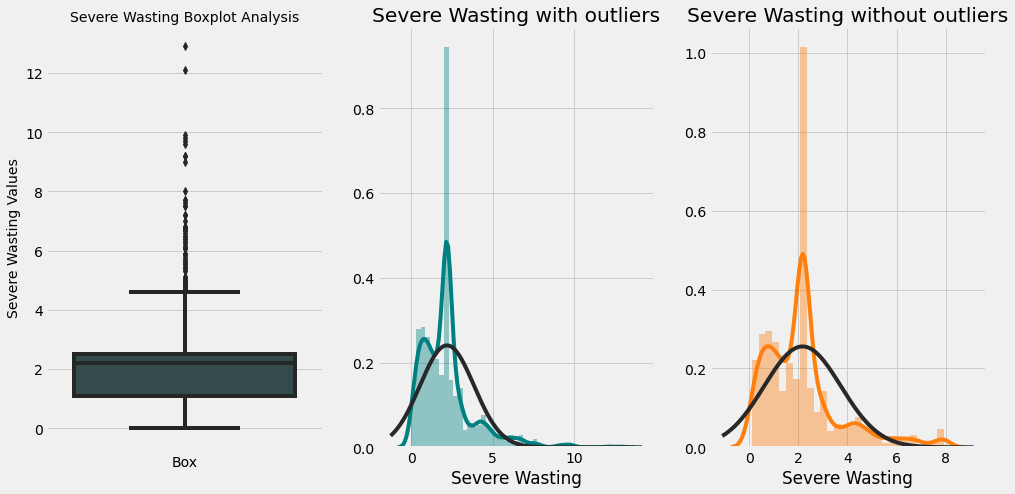

Wasting column --------------------------------------------------------------------------------
no of records with outliers values: 24


,Country,Year,Income Classification,LDC,LIFD,LLDC or SID2,Survey Sample (N),Severe Wasting,Wasting,Overweight,Stunting,Underweight,U5 Population ('000s)
48,BANGLADESH,1997,Lower Middle Income,1.00,1.00,Others,"5,204",6.80,20.70,2.40,59.60,53.60,16160.17
105,BURKINA FASO,2003,Low Income,1.00,1.00,LLDC,"9,290",9.70,21.20,5.40,43.10,35.20,2360.64
106,BURKINA FASO,2006,Low Income,1.00,1.00,LLDC,"4,321",12.10,24.40,7.00,40.00,35.90,2564.72
209,DEMOCRATIC PEOPLE'S REP. OF KOREA (THE),1998,Low Income,0.00,1.00,Others,"1,263",2.19,20.80,6.43,63.90,55.50,2063.74
223,DJIBOUTI,2002,Lower Middle Income,1.00,1.00,Others,"1,425",9.60,19.40,8.40,27.10,24.40,105.43


EDA for Wasting column --------------------------------------------------------------------------------


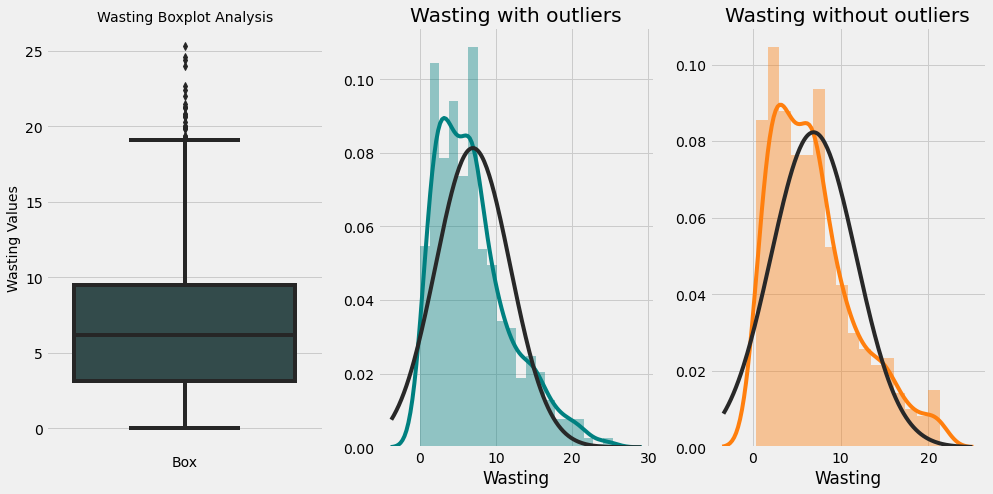

Overweight column --------------------------------------------------------------------------------
no of records with outliers values: 43


,Country,Year,Income Classification,LDC,LIFD,LLDC or SID2,Survey Sample (N),Severe Wasting,Wasting,Overweight,Stunting,Underweight,U5 Population ('000s)
5,ALBANIA,2000,Upper Middle Income,0.00,0.00,Others,"1,382",6.20,12.20,30.10,39.20,17.00,279.83
6,ALBANIA,2005,Upper Middle Income,0.00,0.00,Others,"1,090",3.70,7.30,24.80,26.70,6.60,219.41
7,ALBANIA,2009,Upper Middle Income,0.00,0.00,Others,"1,489",5.90,9.60,23.20,23.20,6.30,179.31
8,ALBANIA,2017,Upper Middle Income,0.00,0.00,Others,"2,367",0.50,1.60,16.40,11.30,1.50,176.52
13,ALGERIA,2002,Upper Middle Income,0.00,0.00,Others,"4,357",5.00,9.60,15.10,24.00,11.10,2877.72


EDA for Overweight column --------------------------------------------------------------------------------


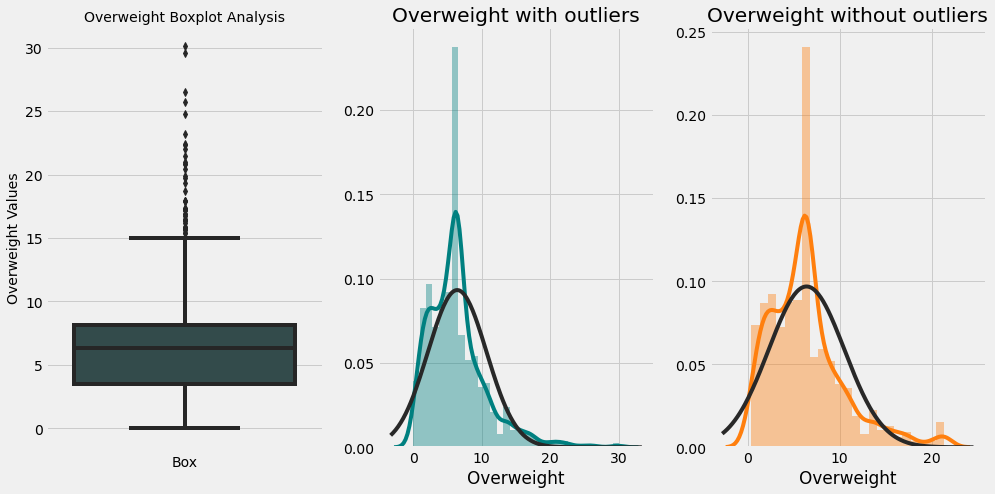

Stunting column --------------------------------------------------------------------------------
no of records with outliers values: 0


,Country,Year,Income Classification,LDC,LIFD,LLDC or SID2,Survey Sample (N),Severe Wasting,Wasting,Overweight,Stunting,Underweight,U5 Population ('000s)


EDA for Stunting column --------------------------------------------------------------------------------


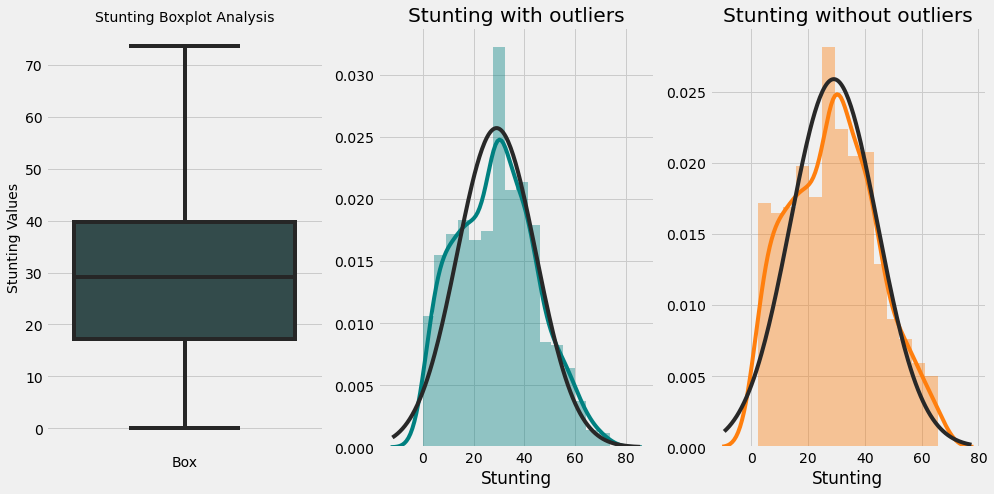

Underweight column --------------------------------------------------------------------------------
no of records with outliers values: 14


,Country,Year,Income Classification,LDC,LIFD,LLDC or SID2,Survey Sample (N),Severe Wasting,Wasting,Overweight,Stunting,Underweight,U5 Population ('000s)
40,BANGLADESH,1986,Lower Middle Income,1.00,1.00,Others,"2,675",2.19,17.30,0.20,70.90,66.80,15384.62
41,BANGLADESH,1990,Lower Middle Income,1.00,1.00,Others,"1,914",2.19,17.50,0.60,63.40,61.50,15889.55
42,BANGLADESH,1991,Lower Middle Income,1.00,1.00,Others,"32,493",2.60,15.20,0.30,73.60,61.20,15998.58
43,BANGLADESH,1992,Lower Middle Income,1.00,1.00,Others,"36,997",3.00,16.10,0.20,71.50,60.60,16042.64
44,BANGLADESH,1993,Lower Middle Income,1.00,1.00,Others,"42,826",2.50,14.00,0.40,69.20,56.10,16047.01


EDA for Underweight column --------------------------------------------------------------------------------


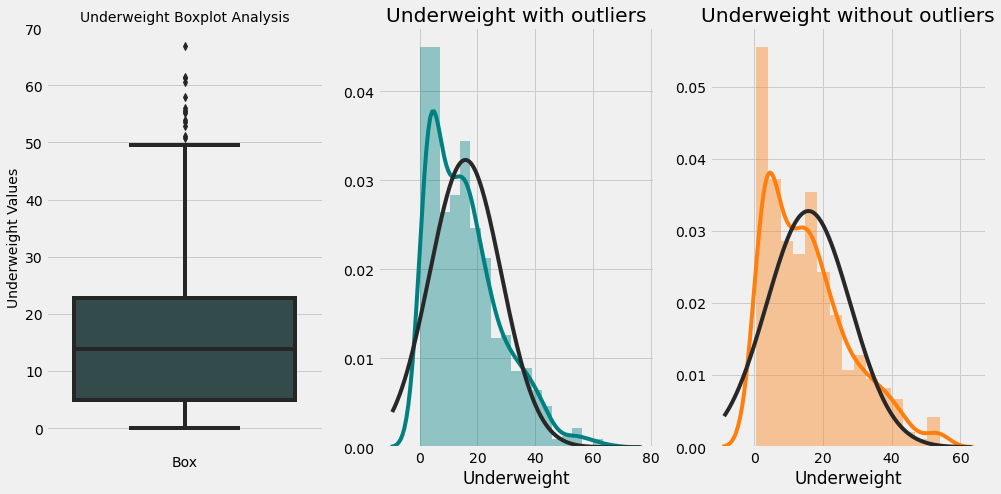

In [11]:
# Outlier, distribution for columns with outliers
boxplotcolumns = ['Severe Wasting', 'Wasting', 'Overweight', 'Stunting',
                  'Underweight']
for cols in boxplotcolumns:
    Q3 = data[cols].quantile(0.75)
    Q1 = data[cols].quantile(0.25)
    IQR = Q3 - Q1

    print(f'{cols.capitalize()} column', '--'*40)
    count = len(data.loc[(data[cols] < (Q1 - 1.5 * IQR)) | (data[cols] > (Q3 + 1.5 * IQR))])
    print(f'no of records with outliers values: {count}')
    
    display(data.loc[(data[cols] < (Q1 - 1.5 * IQR)) | (data[cols] > (Q3 + 1.5 * IQR))].head())
    print(f'EDA for {cols.capitalize()} column', '--'*40)
    odp_plots(data, cols)

del cols, IQR, boxplotcolumns

Observation: There are outliers in the columns plotted above and we also plotted for values without outliers, hardly making any difference.

# Multivariate Analysis

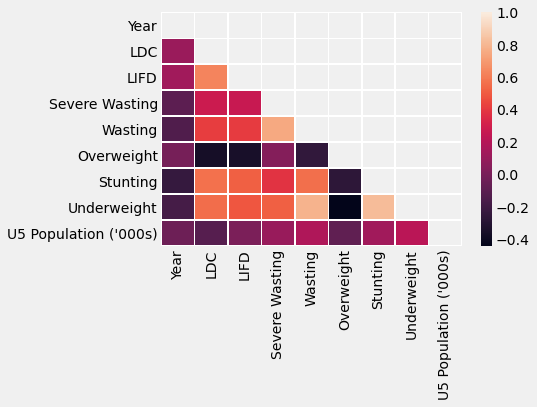

In [12]:
corr = data.corr()
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask,  linewidths = .5 )#, annot = True)

In [13]:
# Filter for correlation value greater than threshold
sort = corr.abs().unstack()
sort = sort.sort_values(kind = "quicksort", ascending = False)
display(sort[(sort > 0.7) & (sort < 1)])

Underweight     Stunting         0.83
Stunting        Underweight      0.83
Wasting         Underweight      0.79
Underweight     Wasting          0.79
Severe Wasting  Wasting          0.76
Wasting         Severe Wasting   0.76
dtype: float64

#### Observation: As expected stunting, underweight and wasting are highly correlated.

# Which country shows highest Underweight percentage? ---> Bangladesh

In [14]:
country = data.loc[:,['Country','Underweight']]
country['percunder'] = country.groupby('Country')['Underweight'].transform('max')
country = country.drop('Underweight',axis=1).drop_duplicates().sort_values('percunder', ascending=False).head()

fig = px.pie(country, names='Country', values='percunder', template='seaborn')
fig.update_traces(rotation=90, pull=[0.2,0.03,0.1,0.03,0.1], textinfo="percent+label", showlegend=False)
fig.show()

# Which country shows highest Overweight percentage? ---> Albania

In [15]:
country = data.loc[:,['Country','Overweight']]
country['percunder'] = country.groupby('Country')['Overweight'].transform('max')
country = country.drop('Overweight',axis=1).drop_duplicates().sort_values('percunder', ascending=False).head()

fig = px.pie(country, names='Country', values='percunder', template='seaborn')
fig.update_traces(rotation=90, pull=[0.2,0.03,0.1,0.03,0.1], textinfo="percent+label", showlegend=False)
fig.show()

# Which income class have highest underweight percentage? ---> Lower Middle Income

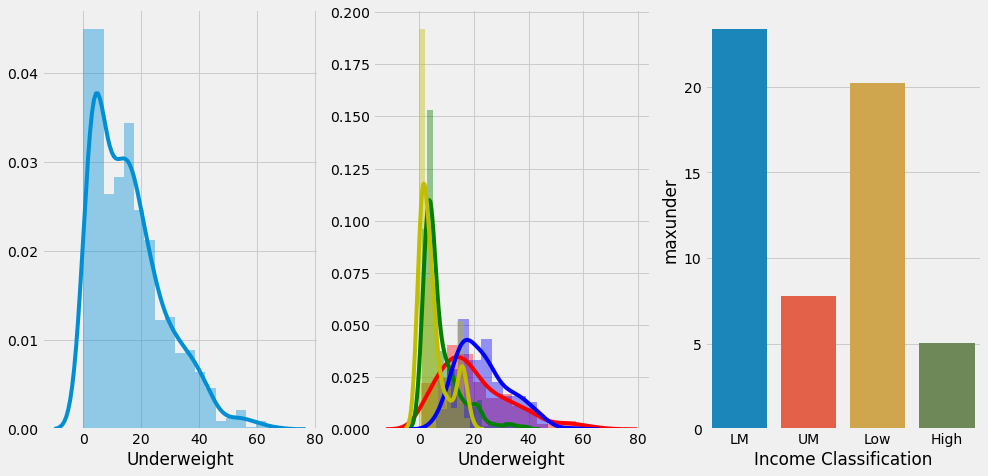

In [16]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))
sns.distplot(data['Underweight'], ax=ax1)

df_LM = data.loc[data['Income Classification'] == 'Lower Middle Income']
df_UM = data.loc[data['Income Classification'] == 'Upper Middle Income']
df_Low = data.loc[data['Income Classification'] == 'Low Income']
df_High = data.loc[data['Income Classification'] == 'High Income']

sns.distplot( df_LM['Underweight'],ax = ax2 , color = 'r')
sns.distplot( df_UM['Underweight'],ax = ax2, color = 'g')
sns.distplot( df_Low['Underweight'],ax = ax2, color = 'b')
sns.distplot( df_High['Underweight'],ax = ax2, color = 'y')

df = data.loc[:,['Income Classification','Underweight']]
df['maxunder'] = df.groupby('Income Classification')['Underweight'].transform('mean')
df = df.drop('Underweight', axis=1).drop_duplicates()
df = data.loc[:,['Income Classification','Underweight']]
df['maxunder'] = df.groupby('Income Classification')['Underweight'].transform('mean')
df = df.drop('Underweight', axis=1).drop_duplicates()

fig = sns.barplot(data=df, x='Income Classification', y='maxunder')
fig.set(xticklabels = ['LM', 'UM', 'Low', "High"])
plt.show()

In [17]:
df = data.loc[:,['Income Classification','Underweight']]
df['maxunder'] = df.groupby('Income Classification')['Underweight'].transform('max')
df = df.drop('Underweight', axis=1).drop_duplicates()

fig = px.pie(df, names='Income Classification', values='maxunder', template='seaborn')
fig.update_traces(rotation=90, pull=0.05, textinfo="percent+label", showlegend=False)
fig.show()

# Underweight percentage in Least Developed Country vs Developed Country

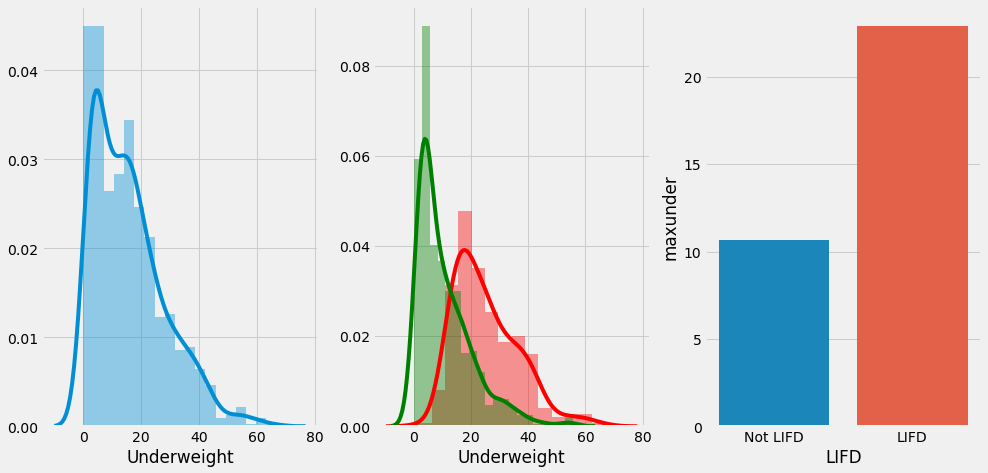

In [18]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))
df_with_LDC = data.loc[data['LDC'] == 1]
df_with_DC = data.loc[data['LDC'] == 0]

sns.distplot(data['Underweight'], ax=ax1)
sns.distplot( df_with_LDC['Underweight'],ax = ax2 , color = 'r')
sns.distplot( df_with_DC['Underweight'],ax = ax2, color = 'g')

df = data.loc[:,['LIFD','Underweight']]
df['maxunder'] = df.groupby('LIFD')['Underweight'].transform('mean')
df = df.drop('Underweight', axis=1).drop_duplicates()

fig = sns.barplot(data=df, x='LIFD', y='maxunder', ax=ax3)
fig.set(xticklabels = ['Not LIFD', 'LIFD'])
plt.show()

Observation: Least developed country(green) has has more no of underweights and no in developed countries are way lesser considerably .

# Low Income Food Deficient Countries Underweight percentages

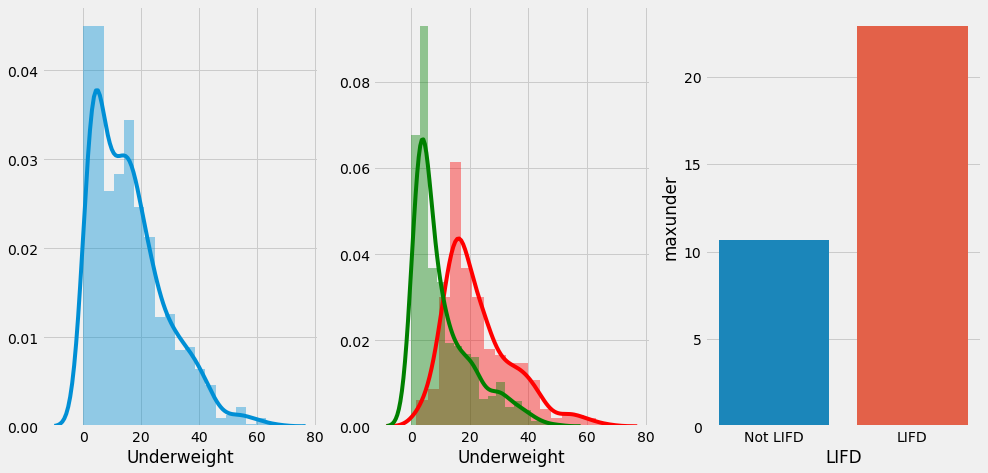

In [19]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))
df_with_LIFD = data.loc[data['LIFD'] == 1]
df_with_NLIFD = data.loc[data['LIFD'] == 0]

sns.distplot(data['Underweight'], ax=ax1)
sns.distplot( df_with_LIFD['Underweight'],ax = ax2 , color = 'r')
sns.distplot( df_with_NLIFD['Underweight'],ax = ax2, color = 'g')

df = data.loc[:,['LIFD','Underweight']]
df['maxunder'] = df.groupby('LIFD')['Underweight'].transform('mean')
df = df.drop('Underweight', axis=1).drop_duplicates()
df = data.loc[:,['LIFD','Underweight']]
df['maxunder'] = df.groupby('LIFD')['Underweight'].transform('mean')
df = df.drop('Underweight', axis=1).drop_duplicates()

fig = sns.barplot(data=df, x='LIFD', y='maxunder')
fig.set(xticklabels = ['Not LIFD', 'LIFD'])
plt.show()

# Underweight Analysis according to Income Group

In [20]:
data["Income Classification"].value_counts()

Lower Middle Income    335
Upper Middle Income    281
Low Income             225
High Income             83
Name: Income Classification, dtype: int64

## Landlocked Developing Countries vs Small Island Developing states vs Others ---> Others

In [21]:
df = data.loc[:,['LLDC or SID2','Underweight']]
df['maxunder'] = df.groupby('LLDC or SID2')['Underweight'].transform('max')
df = df.drop('Underweight', axis=1).drop_duplicates()

fig = px.pie(df, names='LLDC or SID2', values='maxunder', template='seaborn')
fig.update_traces(rotation=90, pull=0.05, textinfo="percent+label", showlegend=False)
fig.show()

# Severe Wasting
### This is the % of children aged 0–59 months who are below minus three standard deviations from median weight-for-height

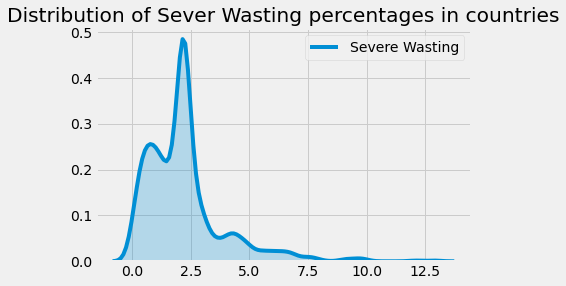

In [22]:
sns.kdeplot(data=data['Severe Wasting'], shade=True)
plt.title('Distribution of Sever Wasting percentages in countries')
plt.show()

We can notice from the distribution plot that the percentage values o as high as 12% in some countries.

From the scatter plot it can be noticed that high severe wasting percentages is mostly found for low survey sample sizes.

# Severe Wasting - Wasting - Overweight - Underweight

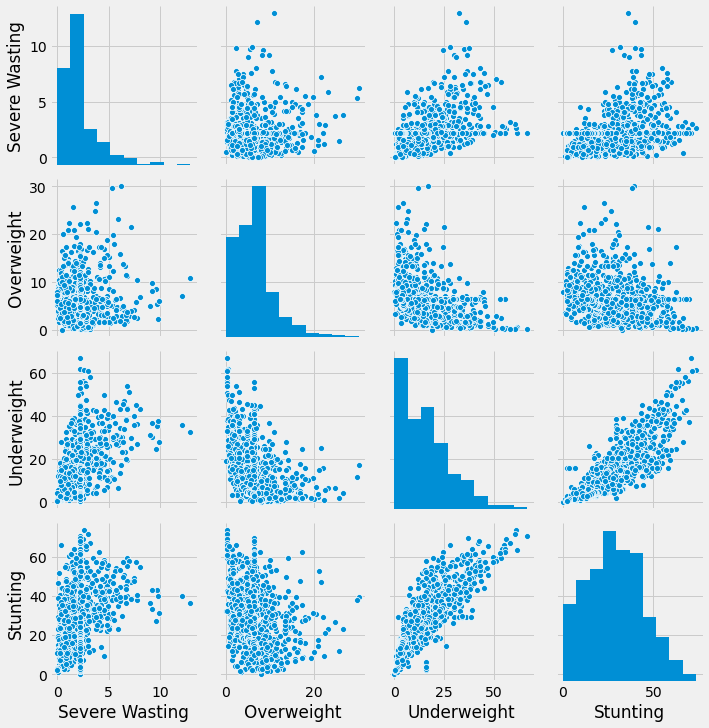

In [23]:
sns.pairplot(data[['Severe Wasting','Overweight','Underweight', 'Stunting']])
plt.show()

# U5 Population
### Population of that country under the age of 5

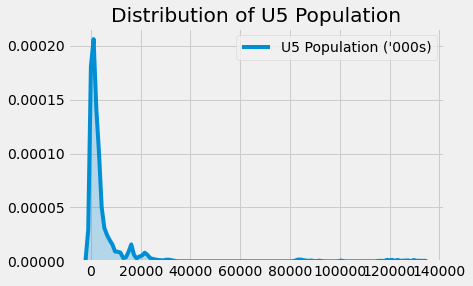

In [24]:
sns.kdeplot(data=data['U5 Population (\'000s)'], shade=True)
plt.title('Distribution of U5 Population')
plt.show()

# Relation of Underweight % to U5 population

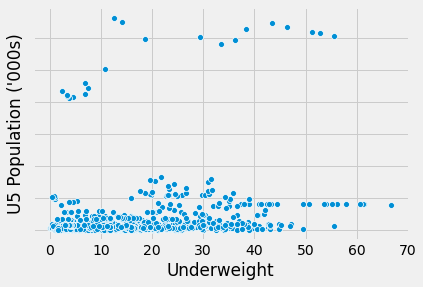

In [25]:
fig = sns.scatterplot(data=data, x='Underweight', y='U5 Population (\'000s)')
fig.set(yticklabels=[])
plt.show()

It can be clearly noticed that for highest populations the underweight percentage is also quite high.

# Which country shows highest underweight count? ---> India

In [26]:
df = data.loc[:,['Country','Underweight','U5 Population (\'000s)']]
df['underweight_count'] = (df['U5 Population (\'000s)'] * df['Underweight'])/100
df.drop(['Underweight','U5 Population (\'000s)'], axis=1, inplace=True)
df['undermean'] = df.groupby('Country')['underweight_count'].transform('mean')
df = df.drop('underweight_count', axis=1).drop_duplicates().sort_values('undermean', ascending=False).head()

fig = px.pie(df, names='Country', values='undermean', template='seaborn')
fig.update_traces(rotation=90, pull=[0.2,0.03,0.1,0.03,0.1], textinfo="percent+label", showlegend=False)
fig.show()

The reason behind this exceptional percentage may be due to the population count or any other factor as well.